# Keyword spotting using CNN on raw waveforms

In [75]:
import warnings; warnings.simplefilter('ignore')
import torch
import torchaudio
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchaudio.datasets import SPEECHCOMMANDS

import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import random
import copy
import numpy as np

import IPython.display as ipd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = 'cpu'

cuda:0


## 1. Dataset & data pre-processing

Train set, test set and validation set are generated regarding the labels we want to work with.  
An "unknown" class is created containing audio samples from random other class.

In [7]:
# labels we want to keep, other words will be changed to "unknown"
labels = ['zero' ,'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

# True if processed_train_list.txt, processed_test_list.txt, processed_validation_list.txt
# have already been created. False to create them.
loadDataFromTxt = True

class Subset(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=False)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            # print(filepath)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]
            
        # full dataset
        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]
            
        # dataset with labels we want to keep
        elif subset == "processed_train":
            self._walker = load_list("processed_train_list.txt")
        elif subset == "processed_test":
            self._walker = load_list("processed_test_list.txt")
        elif subset == "processed_validation":
            self._walker = load_list("processed_validation_list.txt")

# process data to keep labels and create an "unknown" class with random samples of other words
def addUnknownClass(dataset):
    tampDataset = [] # data with labels we want to keep
    tampUnknown = []
    for i in tqdm(dataset) : 
        if i[2] in labels : 
            tampDataset.append(i)
        else : 
            tampUnknown.append(i)
    
    # how many "unknown" data we want
    sizeOfClass = len(tampDataset) // len(labels)
    tampDataset.extend(random.sample(tampUnknown, sizeOfClass))
    return tampDataset

# create text file and indicate instances we want in train, test, validation
def createTextFileFromSet(fileName, dataset):
    fileName = os.path.join(path, fileName)
    file = open(fileName, "w")
    for i in dataset :
        line = i[2]+"/"+i[3]+"_nohash_"+str(i[4])+".wav"+"\n"
        file.write(line)

def createTextFiles(): 
    raw_train_set = Subset("training")
    raw_test_set = Subset("testing")
    raw_validation_set = Subset("validation")
        
    raw_test_set = addUnknownClass(raw_test_set)
    raw_validation_set = addUnknownClass(raw_validation_set)
    raw_train_set = addUnknownClass(raw_train_set)
    
    trainSetName = "processed_train_list.txt"
    testSetName = "processed_test_list.txt"
    validationSetName = "processed_validation_list.txt"
    path = "./SpeechCommands/speech_commands_v0.02"
    
    createTextFileFromSet(trainSetName, raw_train_set)
    createTextFileFromSet(testSetName, raw_test_set)
    createTextFileFromSet(validationSetName, raw_validation_set)
     
if not loadDataFromTxt :
    createTextFiles()
    
train_set = Subset("processed_train")
test_set = Subset("processed_test")
validation_set = Subset("processed_validation")

print("Len train : {}, Len test : {}, Len validation : {}".format(len(train_set), len(test_set), len(validation_set)))

Len train : 42798, Len test : 4517, Len validation : 4007


Preparing data for neural net

In [8]:
# we want to keep tensors and labels
labels = ['zero' ,'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'unknown']

def getIndexFromLabel(label):
    return torch.tensor(labels.index(label))

def getLabelFromIndex(index):
    return labels[index]

# add unknown label, return waveforms and targets as tensors, pad tensors with 0.0
def formatDataset(dataset):
    tensors, targets = [], []

    # Label unknown data to unknown, labels turned to numeric
    for waveform, sample_rate, label, speaker_id, utterance_number in tqdm(dataset):
        tensors.append(waveform)
        if label not in labels : 
            label = "unknown"
        targets.append(getIndexFromLabel(label))

    # samples have not the same length, padding with 0 values
    tensors = [tensor.t() for tensor in tensors] # pad_sequence takes in a list of tensor
    # batch_first and permute to keep data in the right format
    tensors = torch.nn.utils.rnn.pad_sequence(tensors, batch_first = True, padding_value = 0.0).permute(0, 2, 1)
    targets = torch.stack(targets)

    return tensors, targets

Dataloaders

100%|██████████| 512/512 [00:00<00:00, 255957.53it/s]

tensor([[-0.0002,  0.0003, -0.0004,  ..., -0.0005, -0.0005, -0.0002]])
tensor(8)


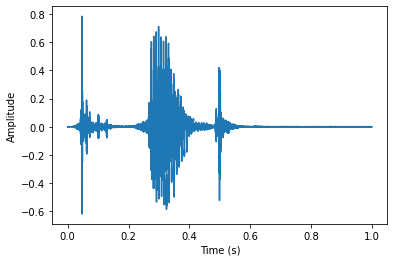

In [17]:
# Dataloader
# check nb of workers
batch_size = 512 # ~42000 instances in train set

train_loader = torch.utils.data.DataLoader(
    dataset = train_set,
    batch_size = batch_size,
    shuffle = True,
    collate_fn = formatDataset)

test_loader = torch.utils.data.DataLoader(
    dataset = test_set,
    batch_size = batch_size,
    shuffle = False,
    collate_fn = formatDataset)

validation_loader = torch.utils.data.DataLoader(
    dataset = validation_set, 
    batch_size = batch_size,
    shuffle = False,
    collate_fn = formatDataset)


test = iter(test_loader)
wavetest = next(test)
print(wavetest[0][0])
print(wavetest[1][0])
# plt.plot((wavetest[0][0]).t().numpy())
ipd.Audio(wavetest[0][0].numpy(), rate=16000)

samplerate = 16000
duration = len(wavetest[0][0].t().numpy())/samplerate
time = np.arange(0,duration,1/samplerate) 
plt.plot(time, wavetest[0][0].t().numpy())
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
del wavetest

## 2. Defining neural networks : CNNrw and Deep CNNrw

#### 2.1 CNNrw : band pass filter + three conv layers

In [96]:

# CNN on raw sound
class CNNrw(nn.Module):
    def __init__(self, out_channels, conv1kernel, conv1stride):
        super(CNNrw, self).__init__()
        # 1 channel, 16000 elements in an instance  
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=out_channels,
                               kernel_size=conv1kernel, stride=conv1stride) # instance size output = 16000 - kernel + 1
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU() # activation
        self.dropoutLinear = nn.Dropout(0.5)
        self.pool = nn.MaxPool1d(4)
        
        self.fc = nn.Linear(out_channels, 11)
        
        self.convLayer = nn.Sequential( # conv layer kernel = 3
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(4),

            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(4),
            )
    
    def forward(self, x):
        # conv layer 1 with large receptive field
        x = self.conv1(x)
        x = self.relu(self.bn(x))
        x = self.pool(x)
        
        x = self.convLayer(x) 

        # linear layer
        x = F.avg_pool1d(x, x.shape[2])
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x

#### 2.2 Deep CNNrw : band pass filter + five conv layers

In [109]:

# Deeper CNN raw waves
class CNNrwD(nn.Module):
    def __init__(self, out_channels = 25, conv1kernel = 3, conv1stride = 1):
        super(CNNrwD, self).__init__()
        # 1 channel, 16000 elements in an instance  
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=out_channels,
                               kernel_size=conv1kernel, stride=conv1stride) # instance size output = 16000 - kernel + 1
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU() # activation
        self.dropoutLinear = nn.Dropout(0.5)
        self.pool = nn.MaxPool1d(3)
        
        self.fc = nn.Linear(out_channels, 11)
        
        self.convLayer = nn.Sequential( # conv layer kernel = 3
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
#             nn.Dropout(0.1),
            nn.MaxPool1d(3),

            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(3),

            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(3),
            
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.MaxPool1d(3),
            
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
#             nn.MaxPool1d(3),
            )
    
    def forward(self, x):
        # conv layer 1 with large receptive field
        x = self.conv1(x)
        x = self.relu(self.bn(x))
        x = self.pool(x)
        
        x = self.convLayer(x) 
#         print(x.shape)

        # linear layer
        x = F.avg_pool1d(x, x.shape[2])
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x

#### 2.3 Train and test function


In [98]:
torch.cuda.empty_cache()
# train / validation function
def train(model, epochs, optimizer):
    print(model)
    lossGraph = []
    validationAccuracyGraph = []
    best_accuracy = 0
    best_model = copy.deepcopy(model.state_dict())
    
    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        scheduler.step()
        # train phase
        model.train()
        loader = train_loader
        
        for batch_index, (x, target) in enumerate(train_loader):

            optimizer.zero_grad() # set gradients to zero
            # data and target to device
            x = x.to(device)
            target = target.to(device)

            out = model(x)
            loss = F.cross_entropy(out.squeeze(), target)
            lossGraph.append(loss)
            loss.backward() # back prop
            optimizer.step()

            if batch_index %20 ==0:
                print('epoch {} batch {} [{}/{}] training loss: {}'.format(epoch,batch_index,batch_index*len(x),
                        len(train_loader.dataset),loss.item()))
#             del x
#             del target

        # test accuracy on validation set
        validationAccuracyGraph.append(test(model, loader = validation_loader))
        
        epoch_acc = validationAccuracyGraph[-1]
        if epoch_acc > best_accuracy :
            best_accuracy = epoch_acc
            best_model = copy.deepcopy(model.state_dict())
        
    return lossGraph, validationAccuracyGraph, best_model
    
def test(model, loader):
    # validation test phase
    model.eval()
    nbOfCorrect = 0
        
    for x, target in loader : 
        # put on gpu
        x = x.to(device)
        target = target.to(device)
        out = model(x)

        loss = F.cross_entropy(out.squeeze(), target)
        prediction = out.argmax(dim=2) # get highest value in outputs
        correctMatrix = prediction.squeeze().eq(target)
        nbOfCorrect += int(correctMatrix.sum().item()) # number of correct pred by batch

    taux_classif = 100. * nbOfCorrect / len(loader.dataset)
    print('Accuracy {} : {}/{} (tx {:.2f}%, err {:.2f}%)\n'.format("validation set" ,nbOfCorrect,
         len(loader.dataset), taux_classif, 100.-taux_classif))
    
    return taux_classif       
        

## 3. Results : comparison of CNNrw and Deep CNNrw

In [ ]:
# CNNrw
nb_epochs = 20
model1 = CNNrw(out_channels = 50, conv1kernel = 120, conv1stride = 20)
model1.to(device)

optimizer = optim.Adam(model1.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4) # reduce learning rate through training

# load best model weights
# model.load_state_dict(best_model_wts)

loss1, accuracy1, best_model1 = train(model1, nb_epochs, optimizer)

In [ ]:
# Deep CNNrw
nb_epochs = 20
model = CNNrwD(out_channels = 50, conv1kernel = 120, conv1stride = 10)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.4) # reduce learning rate through training

# load best model weights
# model.load_state_dict(best_model_wts)

loss, accuracy, best_model = train(model, nb_epochs, optimizer)

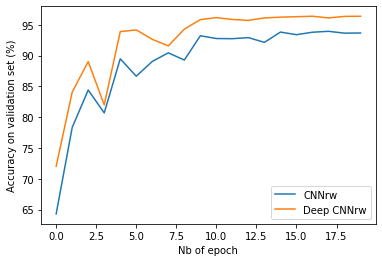

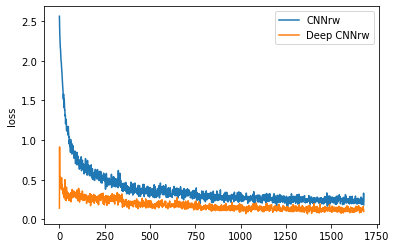

In [135]:
labels_acc = ["CNNrw", "Deep CNNrw"]
plt.plot(accuracy1)
plt.plot(accuracy)
plt.xlabel("Nb of epoch")
plt.ylabel("Accuracy on validation set (%)")
plt.legend(labels_acc)
plt.figure()
plt.plot(loss1)
plt.plot(loss)
plt.ylabel("loss")
plt.legend(labels_acc)

## 4. Annex

#### 4.1 Comparison of architectures regarding number of conv layer

In [ ]:
# CNNrw1
model = CNNrw1(out_channels = 50, conv1kernel = 120, conv1stride = 20)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)

loss1, accuracy1, best_model = train(model, nb_epochs, optimizer)

In [ ]:
# CNNrw2
model = CNNrw2(out_channels = 50, conv1kernel = 120, conv1stride = 20)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)

loss2, accuracy2, best_model = train(model, nb_epochs, optimizer)

In [ ]:
# CNNrw3
model = CNNrw3(out_channels = 50, conv1kernel = 120, conv1stride = 20)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005)

loss3, accuracy3, best_model = train(model, nb_epochs, optimizer)

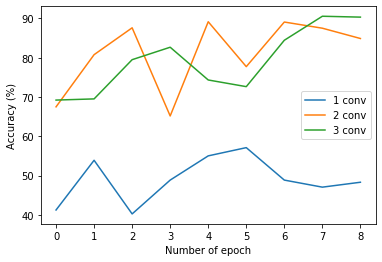

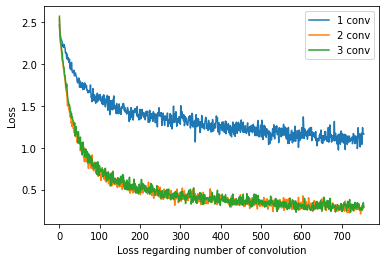

In [52]:
labels_acc = ["1 conv", "2 conv", "3 conv"]
plt.plot(accuracy1)
plt.plot(accuracy2)
plt.plot(accuracy3)
plt.ylabel('Accuracy (%)')
plt.xlabel('Number of epoch')
plt.legend(labels_acc)

plt.figure()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.ylabel('Loss')
plt.xlabel('Loss regarding number of convolution')
plt.legend(labels_acc)

#### 4.2 Determining hyper parameters

In [ ]:
# Choix de la taille du kernel à utiliser pour le filtre passe bande
kernelSize = [20, 40, 80, 120, 160]
losses = []
accuracyList = []
for k in kernelSize : 
    model = CNNrw1(out_channels = 10, conv1kernel = k, conv1stride = 10)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.005)

    loss, accuracy, best_model = train(model, nb_epochs, optimizer)
    losses.append(loss)
    accuracyList.append(accuracy)
    

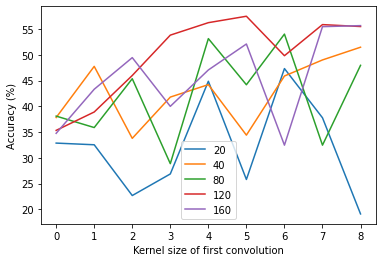

In [24]:
labels_acc = [20, 40, 80, 120, 160]
plt.plot(accuracyList[0])
plt.plot(accuracyList[1])
plt.plot(accuracyList[2])
plt.plot(accuracyList[3])
plt.plot(accuracyList[4])
plt.ylabel('Accuracy (%)')
plt.xlabel('Kernel size of first convolution')
plt.legend(labels_acc)

In [ ]:
# Choix du nombre de feature map en sortie de la première couche convolutive
nb_epochs = 9
channelSize = [30, 40 ,50, 60, 70]
losses2 = []
accuracyList2 = []
for k in channelSize : 
    model = CNNrw1(out_channels = k, conv1kernel = 120, conv1stride = 10)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.005)

    loss, accuracy, best_model = train(model, nb_epochs, optimizer)
    losses2.append(loss)
    accuracyList2.append(accuracy)

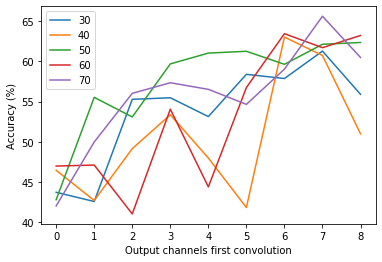

In [26]:
labels_acc = [30, 40 ,50, 60, 70]
plt.plot(accuracyList2[0])
plt.plot(accuracyList2[1])
plt.plot(accuracyList2[2])
plt.plot(accuracyList2[3])
plt.plot(accuracyList2[4])
plt.ylabel('Accuracy (%)')
plt.xlabel('Output channels first convolution')
plt.legend(labels_acc)


#### 4.3 First networks used in this project

In [ ]:

# CNN raw waves 1
class CNNrw1(nn.Module):
    def __init__(self, out_channels = 25, conv1kernel = 3, conv1stride = 1):
        super(CNNrw1, self).__init__()
        # 1 channel, 16000 elements in an instance  
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=out_channels,
                               kernel_size=conv1kernel, stride=conv1stride) # instance size output = 16000 - kernel + 1
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU() # activation
        self.dropoutConv1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool1d(4)
        
        self.fc = nn.Linear(out_channels, 11)
        
        self.convLayer = nn.Sequential( # conv layer kernel = 3
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(4),
            )
    
    def forward(self, x):
        # conv layer 1 with large receptive field
        x = self.conv1(x)
        x = self.relu(self.bn(x))
        x = self.pool(x)
        
        x = self.convLayer(x) 
    
        # linear layer
        x = F.avg_pool1d(x, x.shape[2])
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x

In [ ]:

# CNN raw waves 2
class CNNrw2(nn.Module):
    def __init__(self, out_channels = 25, conv1kernel = 3, conv1stride = 1):
        super(CNNrw2, self).__init__()
        # 1 channel, 16000 elements in an instance  
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=out_channels,
                               kernel_size=conv1kernel, stride=conv1stride) # instance size output = 16000 - kernel + 1
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU() # activation
        self.dropoutConv1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool1d(4)
        
        self.fc = nn.Linear(out_channels, 11)
        
        self.convLayer = nn.Sequential( # conv layer kernel = 3
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(4),
            
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(4),
            )
    
    def forward(self, x):
        # conv layer 1 with large receptive field
        x = self.conv1(x)
        x = self.relu(self.bn(x))
        x = self.pool(x)
        
        x = self.convLayer(x) 
    
        # linear layer
        x = F.avg_pool1d(x, x.shape[2])
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x

In [ ]:

# CNN raw waves 3
class CNNrw3(nn.Module):
    def __init__(self, out_channels = 25, conv1kernel = 3, conv1stride = 1):
        super(CNNrw3, self).__init__()
        # 1 channel, 16000 elements in an instance  
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=out_channels,
                               kernel_size=conv1kernel, stride=conv1stride) # instance size output = 16000 - kernel + 1
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU() # activation
        self.dropoutConv1 = nn.Dropout(0.1)
        self.pool = nn.MaxPool1d(4)
        
        self.fc = nn.Linear(out_channels, 11)
        
        self.convLayer = nn.Sequential( # conv layer kernel = 3
            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(4),

            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),,
            nn.MaxPool1d(4),

            nn.Conv1d(out_channels, out_channels, 3),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.MaxPool1d(4),
            )
    
    def forward(self, x):
        print(x.shape)
        # conv layer 1 with large receptive field
        x = self.conv1(x)
        x = self.relu(self.bn(x))
        x = self.pool(x)
        
        x = self.convLayer(x) 

        # linear layer
        x = F.avg_pool1d(x, x.shape[2])
        x = x.permute(0, 2, 1)
        x = self.fc(x)
        
        return x